In [491]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

%matplotlib inline

# Import the pickled modeling data

In [493]:
partd = pd.read_pickle('/Volumes/ML_projects/Medicare_Fraud_Datasets/processed_data/partd.pkl')
partb = pd.read_pickle('/Volumes/ML_projects/Medicare_Fraud_Datasets/processed_data/partb.pkl')
dmepos = pd.read_pickle('/Volumes/ML_projects/Medicare_Fraud_Datasets/processed_data/dmepos.pkl')
combined = pd.read_pickle('/Volumes/ML_projects/Medicare_Fraud_Datasets/processed_data/combined.pkl')

# Making target binary

In [494]:
partb.TARGET = partb.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)
partd.TARGET = partd.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)
dmepos.TARGET = dmepos.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)
combined.TARGET = combined.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)

# Split data into train/test sets.

In [495]:
X_partb = combined.drop(columns=['TARGET'], axis=1)
y_partb = combined.TARGET

# Downsampling

In [496]:
from imblearn.under_sampling import RandomUnderSampler

In [497]:
rus = RandomUnderSampler(random_state=42)

X_partb, y_partb = rus.fit_sample(X_partb, y_partb)

# Train/Test split

In [498]:
X_train, X_test, y_train, y_test = train_test_split(X_partb, y_partb, test_size=0.2, random_state=0)

print(X_train.shape, y_train.shape, y_test.shape, X_test.shape)

(1580, 206) (1580,) (396,) (396, 206)


### Logistic Regression

In [499]:
from sklearn.linear_model import LogisticRegression

In [500]:
reg = LogisticRegression(max_iter=10**4, penalty='l1', solver='saga', class_weight='balanced')

reg.fit(X_train, y_train)

ValueError: could not convert string to float: 'Physician Assistant'

In [501]:
y_pred = reg.predict(X_test)

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

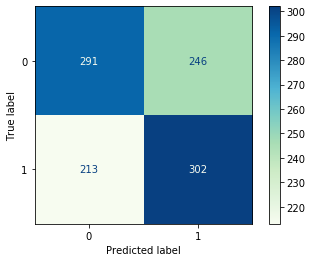

In [480]:
from sklearn import metrics

confusion_matrix = metrics.plot_confusion_matrix(reg, X_test, y_test, cmap= "GnBu")
confusion_matrix;

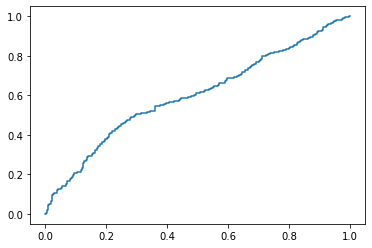

In [481]:
y_pred_prob = reg.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)

In [482]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.54      0.56       537
           1       0.55      0.59      0.57       515

    accuracy                           0.56      1052
   macro avg       0.56      0.56      0.56      1052
weighted avg       0.56      0.56      0.56      1052



# Random Forest

In [452]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [483]:
rf = RandomForestClassifier(n_jobs=-1)

In [484]:
param_grid_rf = {  
    'n_estimators': list(range(1,2000)),
    'criterion': ['gini','entropy'],
    'max_depth': list(range(1,50)),
    'min_samples_leaf': list(range(1,50,1)),
}

In [485]:
grid_tree_rf = RandomizedSearchCV(rf, 
                                  param_grid_rf, 
                                  cv=5,
                                  verbose=1,
                                  n_jobs=-1,
                                  scoring='f1'
                                
)

In [486]:
grid_tree_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.7min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                          

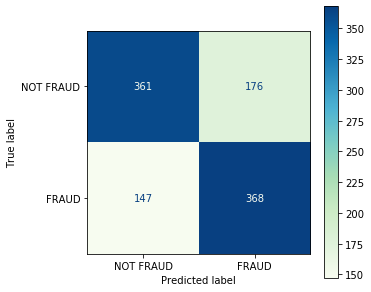

In [487]:
fig, ax = plt.subplots(figsize=(5, 5))
rf_matrix = metrics.plot_confusion_matrix(grid_tree_rf, X_test, y_test, cmap= "GnBu", ax=ax)
ax.set_xticklabels(['NOT FRAUD','FRAUD'])
ax.set_yticklabels(['NOT FRAUD','FRAUD'])
rf_matrix;

In [488]:
ypred = grid_tree_rf.predict(X_test)

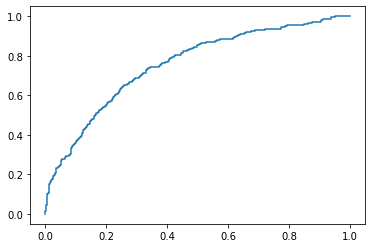

In [490]:
y_pred_prob = grid_tree_rf.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr);

In [460]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, ypred)

0.6481371823340735

In [425]:
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.64      0.71      0.67        80
           1       0.72      0.65      0.68        91

    accuracy                           0.68       171
   macro avg       0.68      0.68      0.68       171
weighted avg       0.68      0.68      0.68       171



In [426]:
grid_tree_rf.best_params_

{'n_estimators': 658,
 'min_samples_leaf': 3,
 'max_depth': 49,
 'criterion': 'gini'}